# Lecture 12 — Bayesian Statistical Inference: V

[Open this notebook in Google Colab](https://colab.research.google.com/github/daanmeerburg/Statistics_meerburg_2026//blob/main/Lectures/Lecture_12_PDM.ipynb)


**Lecturer:** P. D. Meerburg 

*Heavily based on materials by Davide Gerosa (astroML, 2022) and collaborators. See [here](https://github.com/dgerosa/astrostatistics_bicocca_2023/blob/main/README.md) for credits.*

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.
- [Sampler, Samplers, Everywhere...](http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/) by Matt Pitkin.


___


Make sure the python package `dynesty` is installed.

In [2]:
#install dynesty package, but first check if it's already installed
import subprocess
import sys
try:
    import dynesty
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "dynesty"])
# Now you can use dynesty in your code
import dynesty
print("dynesty version:", dynesty.__version__)
# This script checks if the 'dynesty' package is installed.
# If not, it installs the package using pip.

dynesty version: 3.0.0


>##  Practical Evidence Evaluation & Model Selection <a class="anchor" id="two"></a>

We've discussed Bayesian parameter estimation algorithms in detail. Crucially, all you get out of an MCMC are **samples** from the posteriors. You do not get the evidence (denominator in Bayes theorem).

But the evidence is crucial in model comparison... How about it? We already have the AIC and BIC as proxies. Grid-based methods for integrating the likelihood $\times$ prior are far too crude. 

There are some further numerical techniques that we'll briefly discuss, before looking at examples of **Nested Sampling** algorithms to compute the Bayesian evidence. 

### Savage-Dickey Density Ratio

This is great for when we want to compare models that have nested parameters, e.g. (1) a model with just noise, and (2) a model with a signal and noise. 

We need to be able to identify a parameter in the signal model that acts as an amplitude, $A$, that can effectively switch the signal off when it is zero. 

Thus $p_1(d|n) = p_2(d|A=0,n)$.


An example is testing General Relativity. Suppose you want to test a theory which is more generic than GR (say the graviton has a non-zero mass, which implies a dispersion relation for the emitted waves), in that case GR is a special case ($m=0$) of the more generic theory.


With MCMC sampling we can map out the full parameter posterior distribution of model (2). We need to make sure we get good mixing and exploration of the parameter $A$ so that we can reconstruct its posterior density at $A=0$. 

The Bayes factor of Model $2$ (signal and noise) versus Model $1$ (noise alone) can be computed using the **[Savage-Dickey Density Ratio](https://www.jstor.org/stable/2958475?casa_token=Dc8wjaKRj5UAAAAA%3A4IhKgqNXc4jpan6hRxW7tBpXTI4i2236BulPTRxj4FcivD988vqJw-N75Dtw7z4Lh3YtPsDIceS8NDtIXAIRIO1T227h9VYZ2prQpwb46WLBB0GGz8w&seq=1#metadata_info_tab_contents)** approximation,

$$ \mathcal{B} = \frac{\mathcal{Z}_2}{\mathcal{Z}_1} = \frac{p(A=0)}{p(A=0|d,n)}$$

which is the prior density at $A=0$ divided by the conditional posterior density at $A=0$. This is a good model-comparison measure because it is exactly the Bayes factor for nested models, so it rewards models only if the data actually concentrate probability near the null value $A=0$; otherwise the more complex model is penalized by its extra prior volume (Occam's razor). We can easily compute the latter by making a histogram of posterior samples in $A$ and reading off the normalized pdf at $A=0$.


### Product-space Sampling

The name sounds fancy, but is super easy. In this type of model comparison, we never explicitly try to compute the Bayesian evidence. 

- We run a big MCMC chain that includes all parameters of all models, in addition to a model indexing parameter, $n$. 
- We define distinct ranges for this parameter, such that in certain sampling ranges it will trigger one of the model likelihoods to be used, e.g. if $-0.5<n<0.5$ use the likelihood for model $1$. 
- After sampling sufficiently long, the MCMC chain will spend different amounts of time in differnt regions of $n$ in proportion to the Bayesian odds ratio. 
- Hence, the ratio of samples in model sub-ranges of $n$ gives the Bayesian odds ratio. Simple!
- This is heavily used in gravitational-wave searches for Pulsar Timing arrays, see [https://arxiv.org/abs/1801.02617](https://arxiv.org/abs/1801.02617), [https://arxiv.org/abs/2009.04496](https://arxiv.org/abs/2009.04496), and [https://arxiv.org/abs/2006.04810](https://arxiv.org/abs/2006.04810). 
- Cosmology example: compare $\Lambda\mathrm{CDM}$ vs $w\mathrm{CDM}$ vs curved models by introducing a model index parameter that switches which likelihood/parameter set is active; the fraction of samples in each index gives odds.
- Particle physics example: compare background-only vs signal+background hypotheses in a resonance (bump-hunt) search by including a model index that toggles the signal amplitude/shape.
- Refs [here](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1995.tb02042.x) and [here](https://amstat.tandfonline.com/doi/abs/10.1198/10618600152627924?casa_token=Kgpt2ZvdMrcAAAAA%3Al5JB7EitQ7MjPmxBObu2XJXocZCE1tI2-ZAceCwBjJOi2TRajF7SaxFcQjo1Nn5AF9q6vKhkxpBd&#.YEZH4F1KiLo).

### Thermodynamic Integration

This technique is pretty fancy, and is derived from analogies with thermodynamics. It is used for exact calculation of the Bayesian evidence. 

- Many MCMC chains are launched in parallel. However, their likelihoods differ slightly in their "temperature", $T$. We actually use the inverse temperature $\beta=1/T$ when writing the math. The temperature of a chain is used to modify the likelihood as follows, where 

$$ p(d|\theta)_\beta = p(d|\theta)^\beta = p(d|\theta)^{1/T}.$$

- The $\beta=1$ (i.e., $T=1$) chain corresponds to the actual model likelihood. In the limit $T\to\infty$ (i.e., $\beta\to 0$), the likelihood is flattened to $1$, so you recover the prior. 
- Thus, higher-$T$ chains take roots of the likelihood, smoothing it out and making it more similar to the prior, which helps exploration and mixing. 
- Crucially, we can use this continuous path from prior to posterior to compute the evidence:

$$ \ln\mathcal{Z} = \int_0^1 \langle \ln p(d|\theta)\rangle_\beta\, d\beta, $$

where we take the mean log-likelihood of each $\beta$ chain, then integrate over $\beta$ to get the log-evidence. This works because $\mathcal{Z}(\beta)=\int p(d|\theta)^\beta p(\theta) d\theta$, so $\partial_\beta \ln\mathcal{Z}=\frac{1}{\mathcal{Z}}\int p(d|\theta)^\beta p(\theta)\ln p(d|\theta) d\theta=\langle\ln p(d|\theta)\rangle_\beta$; the evidence is the area under that curve. Refs [here](https://www.jstor.org/stable/2676756?casa_token=nGU-oa0w6lQAAAAA%3A8UNqj0_rBP7aZ4vocZ_NzbxKhre4WvzhbNOs_TTI_FfexQmppcxQSlxaO5PCHPZNAw9fZUmy4rPeXLe_CVJgAD2AYR6qS8D6xQDicpc1R45ZhjEtOV4&seq=1#metadata_info_tab_contents), and [here](https://link.springer.com/content/pdf/10.1007/BF01406511.pdf).



### Nested Sampling

Nested sampling is a very different MCMC method from Metropolis-Hastings or even Gibbs approaches. It's very recent and nonetheless very popular. The [first paper is from 2004 by Skilling](https://ui.adsabs.harvard.edu/abs/2004AIPC..735..395S).


- One starts with many points spread throughout the prior volume.
- The points are ranked in terms of their likelihood.
- The lowest ranked point is removed, and a higher likelihood point is randomly added.
- This is repeated, until the cluster of points climbs up the likelihood surface, accumulating Bayesian evidence information along the way. 

The prior volume is defined as $dX = p(\theta)d^n\theta$ such that $X(\lambda) = \int_{p(d|\theta)>\lambda}p(\theta)d^n\theta$, where the integral is over the model parameter region that exceeds the iso-likelihood contour $p(d|\theta)=L(\theta)=\lambda$.

This transforms the evidence integral into 

$$\mathcal{Z} = \int p(d|\theta)p(\theta)d^n\theta = \int_0^1 L(X)dX.$$


So nested sampling turns and $n$ dimensional integral into a 1D integral over $X$, and hence makes evidence calculations tractable (and they are 'free' as the sampling proceeds).


There is a very nice presentation from [Jonathan Pritchard](https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/astrophysics/public/icic/data-analysis-workshop/2016/NestedSampling_JRP.pdf) explaining nested sampling. Especially the figures are extremely useful. 

([See also](https://en.wikipedia.org/wiki/Nested_sampling_algorithm))


The form of the $X_{i}$ is not unique, but it needs to be an estimator of the amount of prior mass in the parameter space of all points with likelihood greater than $L_i$. See [Skilling 2006](https://projecteuclid.org/journals/bayesian-analysis/volume-1/issue-4/Nested-sampling-for-general-Bayesian-computation/10.1214/06-BA127.full) for more.


There are several popular packages that perform nested sampling, and not only do they all compute the Bayesian evidence but they also produce posterior samples as a by-product. 


By far the most historically well known is [`MultiNest`](https://github.com/rjw57/MultiNest) and its Python wrapper [`PyMultiNest`](https://johannesbuchner.github.io/PyMultiNest/). It used to be (and may still be) a bit of a pain to install though (there is C and Fortran involved). Refs [here](https://ui.adsabs.harvard.edu/abs/2004AIPC..735..395S/abstract), and [here](https://academic.oup.com/mnras/article/398/4/1601/981502?login=true).


There is a very popular package in cosmollgy: [`PolyChord`](https://github.com/PolyChord). See this [paper](https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/astrophysics/public/icic/data-analysis-workshop/2016/NestedSampling_JRP.pdf) and this [paper](https://arxiv.org/abs/1506.00171). This is truely state-of-the-art and even has a pro version for industry. Installation is not difficult but the package is written in fortran (with wrappers). Hence installation on google colab might be challanging. 

Here we will consider a sampler (Dynesty) that is written in python and thus can be easily used in Google colab. After this, there will be cells that will make an attempt to run polychord. Perhaps that will be useful when conducting your project. 

---

### Dynesty <a class="anchor" id="twoa"></a>

It's as recent as 2019. https://arxiv.org/abs/1904.02180

![](https://github.com/joshspeagle/dynesty/blob/master/docs/images/title.gif?raw=true)

This example comes from the [dynesty](https://arxiv.org/abs/1904.02180) ["crash course"](https://dynesty.readthedocs.io/en/latest/crashcourse.html). We define our likelihood to be a $3\mathrm{D}$ correlated multivariate Gaussian distribution, and our prior to be uniform in each dimension from $-10$ to $10$.

In [7]:
import dynesty
import numpy as np

# Define the dimensionality of our problem.
ndim = 3

# Define our 3-D correlated multivariate normal likelihood.
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms
Cinv = np.linalg.inv(C)  # define the inverse (i.e. the precision matrix)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim +
                np.log(np.linalg.det(C)))  # ln(normalization)


In [8]:
# Define our log-likelihood function.
def loglike(x):
    """The log-likelihood function."""

    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm # Notice I need the correct normalization now! This is important for evidence calculations.
 
# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    return 10. * (2. * u - 1.) #when u=0, return -10; when u=1, return 10

Run the sampler. 

In [9]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

250it [00:00, 2492.44it/s, bound: 0 | nc: 1 | ncall: 823 | eff(%): 30.377 | loglstar:   -inf < -741.827 <    inf | logz: -747.800 +/-  0.107 | dlogz: 743.356 >  0.509]

4838it [00:04, 1159.27it/s, +500 | bound: 10 | nc: 1 | ncall: 24091 | eff(%): 22.627 | loglstar:   -inf < -0.314 <    inf | logz: -9.199 +/-  0.130 | dlogz:  0.001 >  0.509]


You've just estimated the Bayesian evidence and posterior. Plot the results. These figures will have an $x$-axis that is $-\ln X$ which is a bit confusing to think about to begin with, but remember that we are moving up the likelihood contours when going from left to right on the graphs. If you are confused, look at the figures in the presentation linked above. 

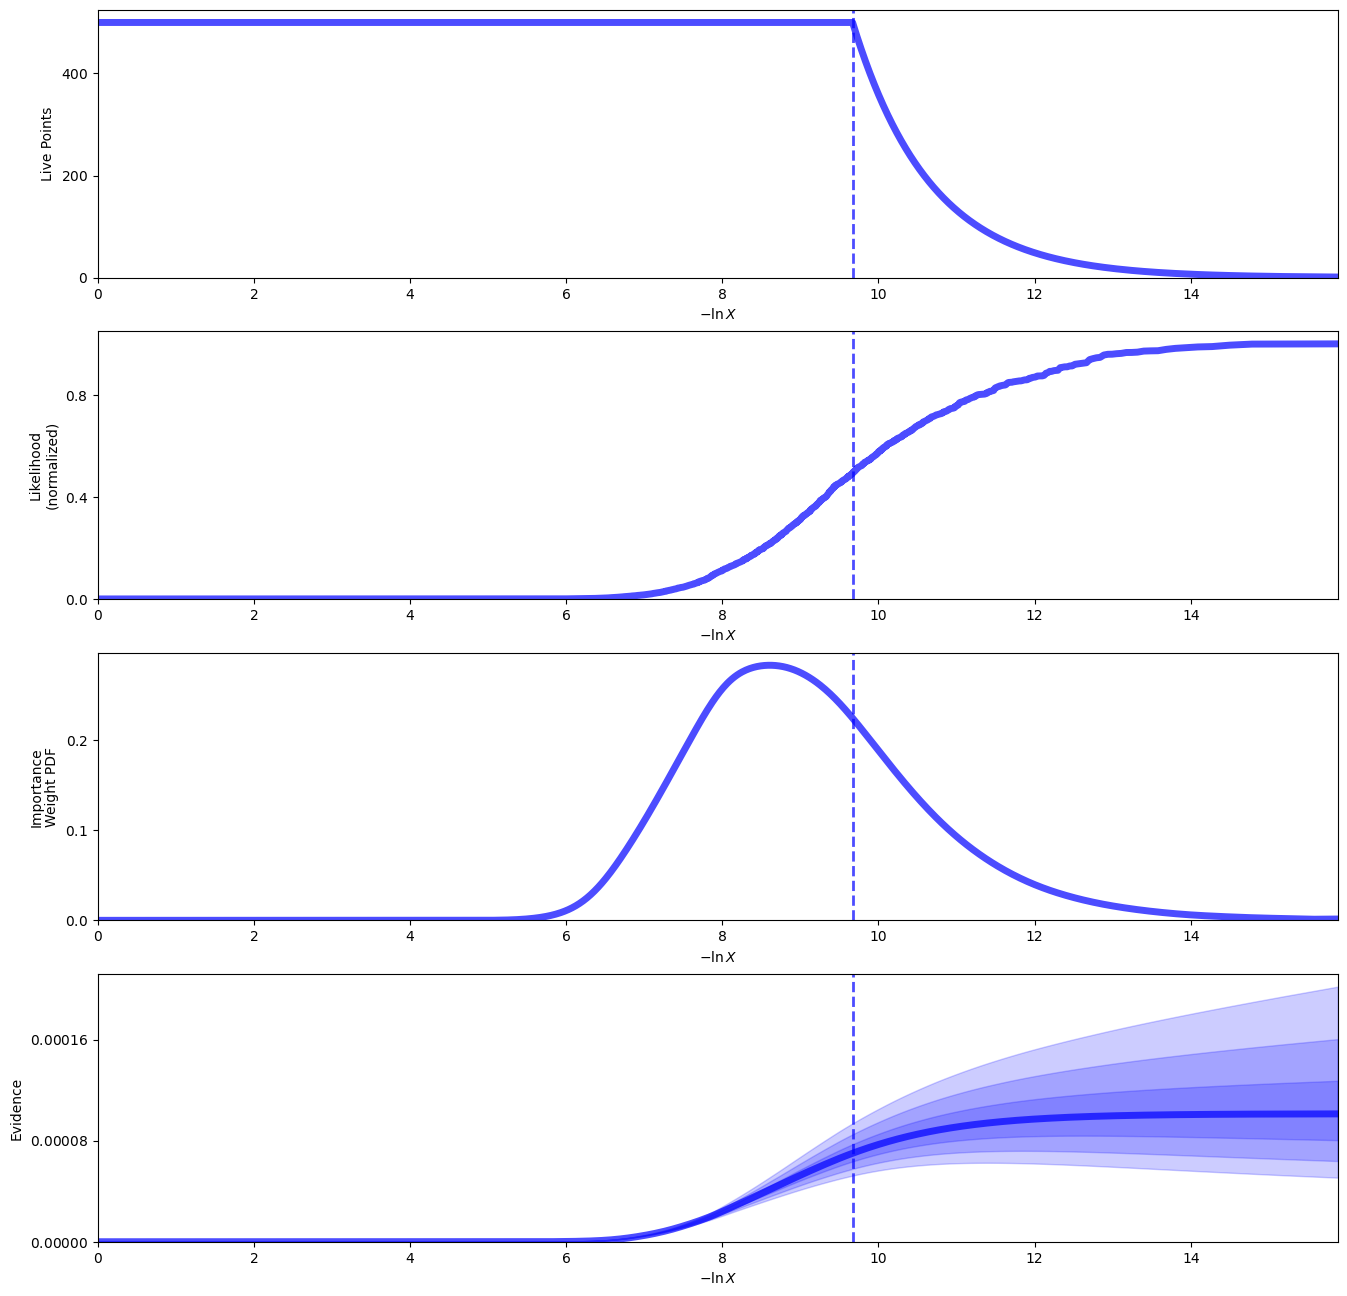

In [10]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

How to interpret this... ![From the arXiv](Dynesty_Sampler.png)



Plot parameter traces and 1-D marginalized posteriors. On the left panels, you'll see that the live points started out scattereed across the prior volume, then move inwards as the sampler climbs the likelihood.

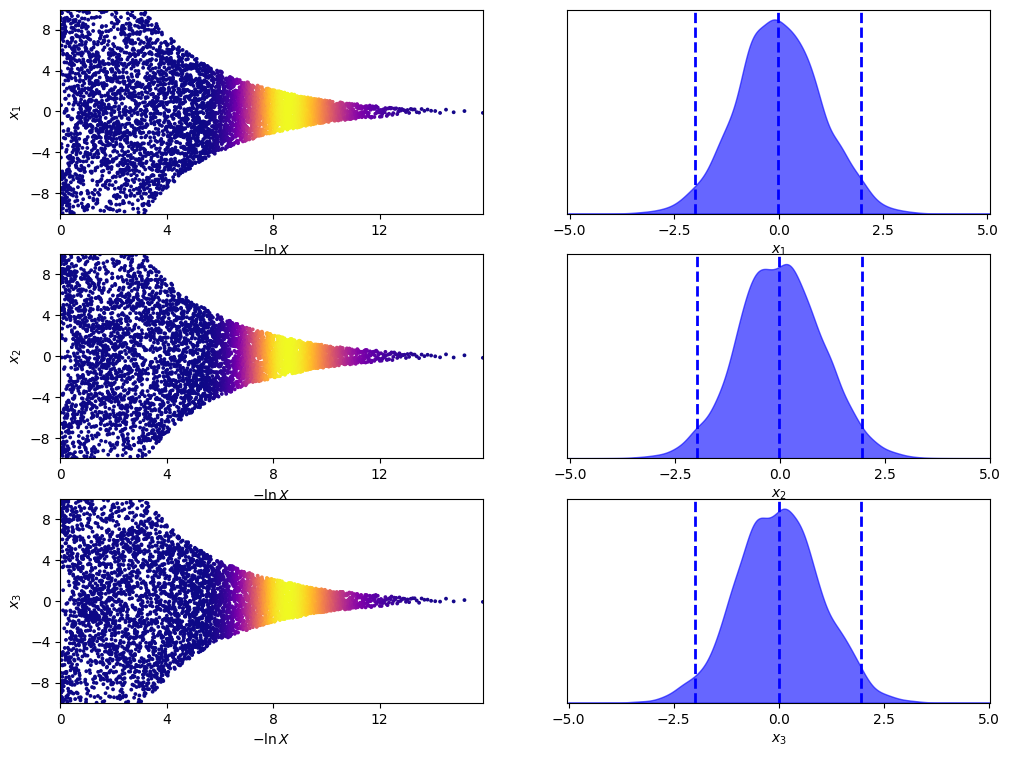

In [11]:
tfig, taxes = dyplot.traceplot(sresults)

Plot the 2-D marginalized posteriors using `dynesty` routines. (But you could also use `corner` if you wish).

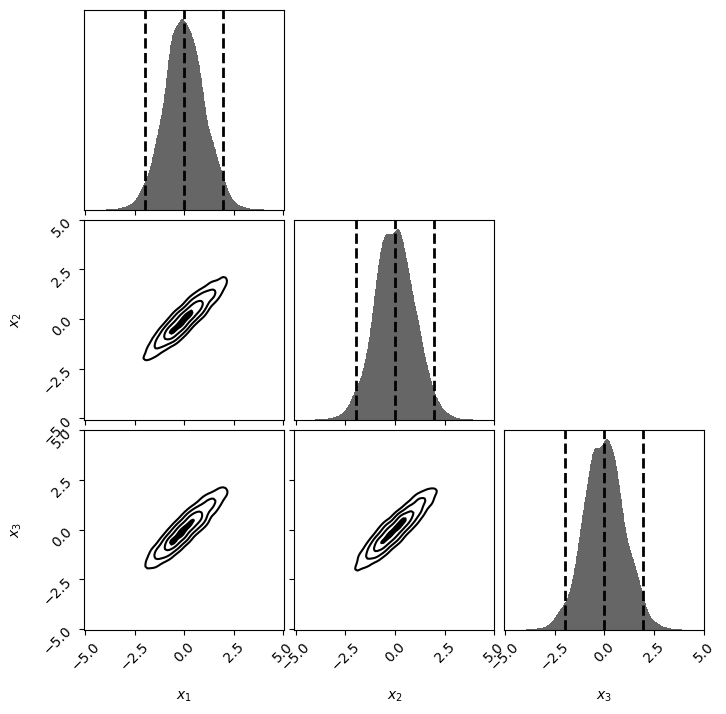

In [12]:
cfig, caxes = dyplot.cornerplot(sresults)

`dynesty` also lets you access many other utilities and analysis outputs. See below. 

In [14]:
from dynesty import utils as dyfunc


# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights


evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

Bayesian evidence 0.00010116963804380562
68% parameter credible regions are:
 [[-0.9480601815053239, 0.9901005653922172], [-0.9650672531492371, 0.9968610205824151], [-0.9981936874384029, 0.9832052953274598]]

Mean and covariance of parameters are: [ 0.00464236 -0.0090324  -0.00231794]
[[1.00537744 0.9479531  0.95729488]
 [0.9479531  0.99574246 0.9529595 ]
 [0.95729488 0.9529595  1.01653425]]


If you want to plot your posterior samples using `corner` or another package, then access the *equally weighted samples*. 

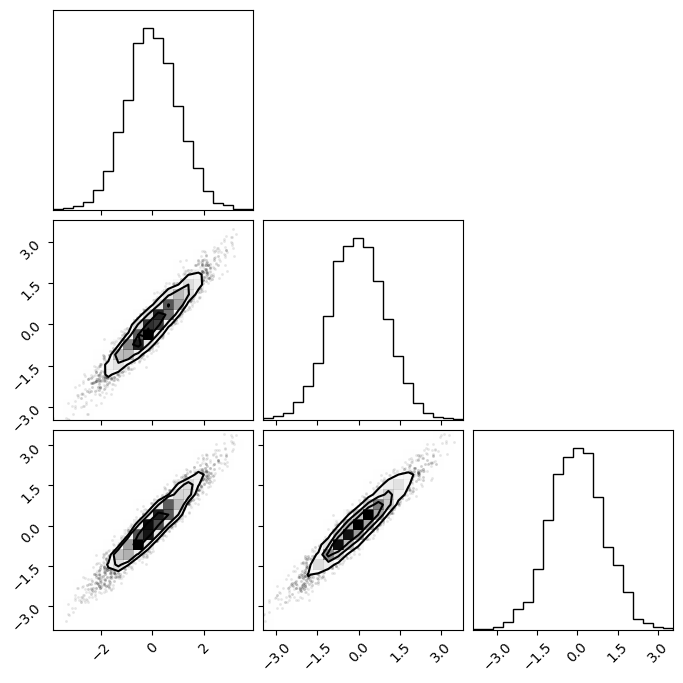

In [15]:
import corner
corner.corner(samples_equal);

The code even helpfully tells you what work you should be citing based on the run configurations that you used.

In [10]:
print(sampler.citations)

Code and Methods:
Speagle (2020): ui.adsabs.harvard.edu/abs/2020MNRAS.493.3132S
Koposov et al. (2024): doi.org/10.5281/zenodo.3348367

Nested Sampling:
Skilling (2004): ui.adsabs.harvard.edu/abs/2004AIPC..735..395S
Skilling (2006): projecteuclid.org/euclid.ba/1340370944



Bounding Method:
Feroz, Hobson & Bridges (2009): ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F

Sampling Method:




There is a lot to explore in the `dynesty` package. It is not a panacea, and there are some things you may have to tune, e.g. the **number of initialized live points**, and **the evidence tolerance**. Dig into these caveats in your own time for your own research problems.

Additionally, it implements **dynamic nested sampling** that dynamically allocates live points to explore higher posterior regions better at the expense of increasing the relative evidence uncertainty. See https://dynesty.readthedocs.io/en/latest/dynamic.html. 

In [11]:
## "Dynamic" nested sampling.

#dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim)
#dsampler.run_nested()
#dresults = dsampler.results

### Some harder examples... 

Have a look at some of these runs!

https://dynesty.readthedocs.io/en/latest/examples.html

### PolyChord <a class="anchor" id="twoc"></a>

PolyChord is a nested sampling algorithm that is very popular in cosmology. It is designed to scale well with higher-dimensional parameter spaces, and it interfaces cleanly with cosmology codes (e.g., via CosmoMC).


Run PolyChord on the same 3D Gaussian likelihood used above and compare the diagnostics to the `dynesty` run. We will use the same number of live points as the default `dynesty` settings (500) for a fair comparison.


In [17]:
# Run PolyChord inside a module-loaded shell. 
# This reinstalls pypolychord inside that shell to match the loaded GCC/OpenMPI. -- will likely only work on HPC systems with module system.
import sys, subprocess

py = sys.executable
cmd = f"""
module load GCCcore/12.3.0
module load OpenMPI/4.1.5-GCC-12.3.0

# Suppress noisy MPI/PSM warnings on login/interactive nodes
export OMPI_MCA_btl=self,tcp
export OMPI_MCA_pml=ob1
export OMPI_MCA_hwloc_base_binding_policy=none
export OMPI_MCA_rmaps_base_oversubscribe=1

# If already installed with these modules, you do not need to reinstall each time.

# Now run PolyChord in the same shell
{py} - <<'PYCODE'
import inspect
import numpy as np
from pypolychord import run_polychord, PolyChordSettings

print('run_polychord signature:', inspect.signature(run_polychord))

# Redefine the 3D Gaussian example locally (avoid reliance on notebook state)
ndim = 3
C = np.identity(ndim)
C[C==0] = 0.95
Cinv = np.linalg.inv(C)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(np.linalg.det(C)))

def loglikelihood(theta):
    return -0.5 * np.dot(theta, np.dot(Cinv, theta)) + lnorm, []

def prior(cube):
    return 10. * (2. * cube - 1.)

settings = PolyChordSettings(ndim, 0)
settings.nlive = 5000
settings.file_root = "polychord_demo"
settings.num_repeats = 100  # increase for better sampling

settings.base_dir = "chains"
settings.max_ndead = 50000  # allow more iterations
settings.precision_criterion = 0.001  # smaller => more samples


# Correct signature: (loglikelihood, nDims, nDerived, settings, prior=...)
run_polychord(loglikelihood, ndim, 0, settings, prior=prior)

print("Finished. Check chains/polychord_demo.stats for log-evidence.")
PYCODE
"""

subprocess.check_call(["bash", "-lc", cmd])


run_polychord signature: (loglikelihood, nDims, nDerived, settings, prior=<function default_prior at 0x7fa2352562a0>, dumper=<function default_dumper at 0x7fa235256480>)
PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.22.3
  release: 22nd Nov 2025
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :    5000
nDims    :       3
nDerived :       0
Doing Clustering
Synchronous parallelisation
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file to chains/polychord_demo.resume

Resuming from previous run
number of repeats:           15
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         8246                              |
| log(Z) =           -8.87400 +/-            0.12004 |
|______________

0

In [18]:
# Diagnostics: confirm likelihood normalization and check PolyChord weights.
import numpy as np

# Recompute lnorm locally if not defined in the current kernel
try:
    lnorm
except NameError:
    ndim = 3
    C = np.identity(ndim)
    C[C==0] = 0.95
    Cinv = np.linalg.inv(C)
    lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(np.linalg.det(C)))

print("lnorm:", lnorm)

# Inspect PolyChord chain columns and weights using anesthetic.
from anesthetic import read_chains
poly = read_chains("chains/polychord_demo")
print("PolyChord columns:", poly.columns)
print("PolyChord weights summary:")
try:
    w = poly.get_weights()
    print("  weights: min", np.min(w), "max", np.max(w), "sum", np.sum(w))
except Exception as e:
    print("  could not access weights:", e)


lnorm: -0.2934386945562415
PolyChord columns: MultiIndex([(           0,                                ''),
            (           1,                                ''),
            (           2,                                ''),
            (      'logL',                '$\ln\mathcal{L}$'),
            ('logL_birth', '$\ln\mathcal{L}_\mathrm{birth}$'),
            (     'nlive',               '$n_\mathrm{live}$')],
           names=[None, 'labels'])
PolyChord weights summary:
  weights: min 0.0 max 1.0 sum 1645.2362900742578


In [20]:
# Install anesthetic for weighted posterior plotting (works in Colab and HPC).
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "anesthetic"])


0

Using columns: [0, 1, 2]


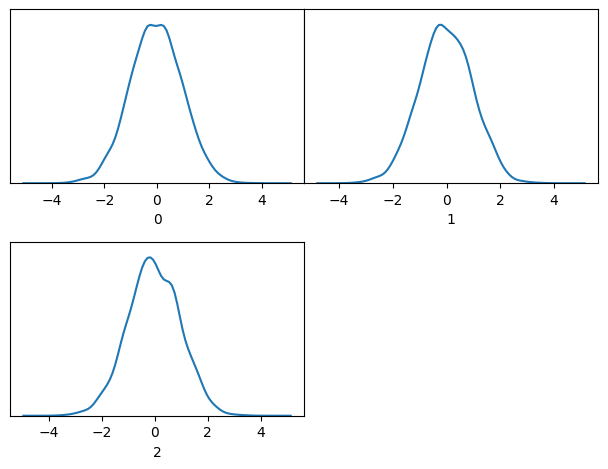

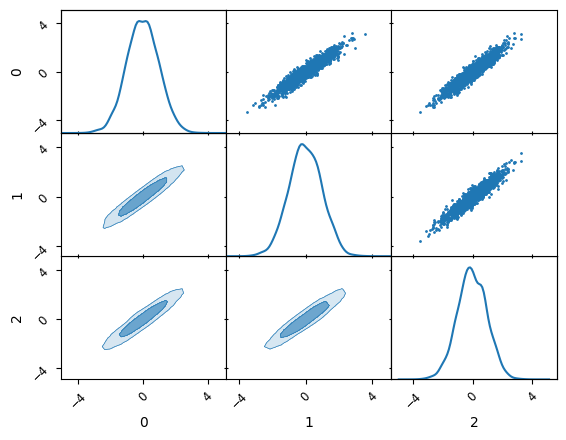

In [19]:
# Plot PolyChord posteriors with anesthetic (robust column handling).
from anesthetic import read_chains
import matplotlib.pyplot as plt

samples = read_chains("chains/polychord_demo")

# Drop label levels to get flat columns, then take first 3 parameters
s = samples.drop_labels()
params = list(s.columns[:3])
print("Using columns:", params)

s.plot_1d(params)
s.plot_2d(params)

plt.show()


PolyChord ESS (weighted): 2366.1823849976454


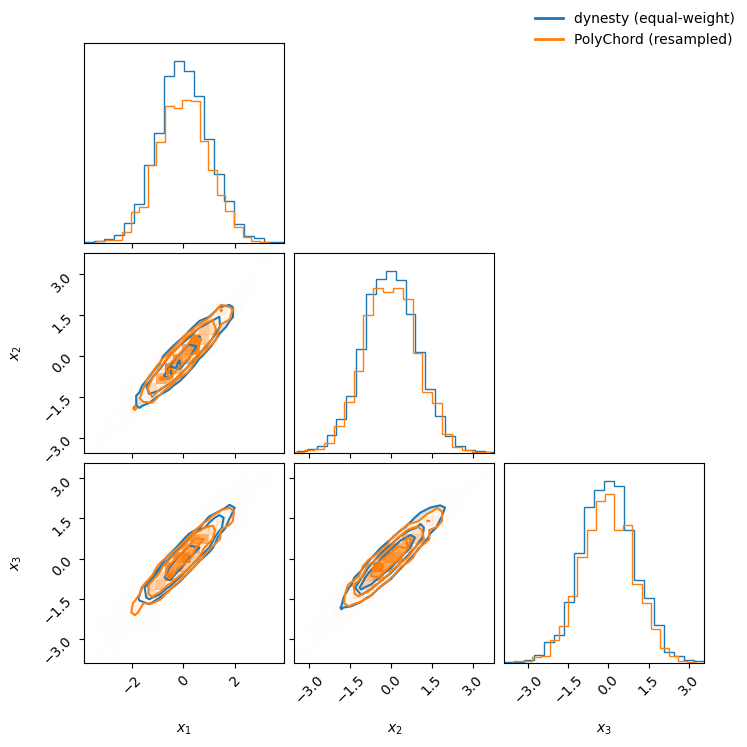

In [22]:
# Compare dynesty vs PolyChord with equal-weight resampling and ESS.
import numpy as np
import matplotlib.pyplot as plt
import corner
from anesthetic import read_chains

# Dynesty equal-weight samples
try:
    dyn_samples = samples_equal
except NameError:
    raise SystemExit("Run the dynesty section first to define `samples_equal`.")

# PolyChord: read weighted samples
poly = read_chains("chains/polychord_demo").drop_labels()
poly_params = np.asarray(poly.iloc[:, :3])

# Weights (normalize) and ESS
try:
    w = np.asarray(poly.get_weights())
    w = w / np.sum(w)
    ess = (np.sum(w) ** 2) / np.sum(w ** 2)
    print("PolyChord ESS (weighted):", ess)
except Exception as e:
    w = None
    print("Could not access weights, using unweighted samples.")
    print("Error:", e)

# Resample to equal weights for fair overlay
if w is not None:
    n = min(len(poly_params), 5000)
    idx = np.random.choice(len(poly_params), size=n, replace=True, p=w)
    poly_eq = poly_params[idx]
else:
    poly_eq = poly_params

fig = corner.corner(dyn_samples, labels=[r"$x_1$", r"$x_2$", r"$x_3$"],
                    color="C0", plot_datapoints=False, fill_contours=True)
corner.corner(poly_eq, fig=fig, color="C1", plot_datapoints=False,
              fill_contours=False, linewidths=1.5)

handles = [
    plt.Line2D([0], [0], color="C0", lw=2, label="dynesty (equal-weight)"),
    plt.Line2D([0], [0], color="C1", lw=2, label="PolyChord (resampled)"),
]
fig.legend(handles=handles, loc="upper right", frameon=False)
plt.show()


###  UltraNest <a class="anchor" id="twob"></a>

*Refs: MLFriends (Buchner, 2014; 2019) using UltraNest https://johannesbuchner.github.io/UltraNest/*

If you want to explore another sampler for your research, you can look into UltraNest. 

This is a nice example from the [UltraNest's documentation](https://johannesbuchner.github.io/UltraNest/using-ultranest.html), which involves fitting a **spectral line feature**. There are many other tutorials on the documentation to dig into in your own time.

To see how `UltraNest` works compared to standard MCMC algorithms, go [here](https://johannesbuchner.github.io/UltraNest/method.html#visualisation). 



### Take home message


There is a ton more to explore in nested sampling, evidence evaluation, model comparison, and parameter estimation.

Alas, we must move on. However, these hands-on tutorials using real packages gives you an idea of the rich array of resources you can use for your own research.

Make sure you know what is going on under the hood, but remember we're physicists after all!

>## Assignment — Evidence for a bump hunt

Let’s reuse the **Higgs-style bump hunt** assignment from Lecture 11, but now use **nested sampling** to compute Bayesian evidences and compare models.

### Tasks

1) Load the same dataset from Lecture 11: `data/higgs_binned.npy`.

2) Define the **signal+background** model used previously:

$$
\lambda_i = \Delta m \left[ A \exp\!\left(-\frac{(m_i-\mu)^2}{2\sigma^2}
\right) + B \exp(-\alpha m_i) 
\right].
$$

3) Implement a **nested-sampling** analysis (e.g. using `dynesty` or `PolyChord`) for the parameters $\{\mu,\sigma,A,B,\alpha\}$. Choose sensible priors (you may fix \(\sigma\) if you want to reduce dimensionality).

4) As a **null model**, fit a **background-only** model by setting \(A=0\):

$$
\lambda_i = \Delta m \, B \exp(-\alpha m_i).
$$

5) Compute the Bayesian evidence for both models and report the **Bayes factor**. Which model is favored by the data?

6) Make a corner plot of the **signal+background** posterior and compare the constraints to your MCMC results from Lecture 11.

*Tip:* If your evidence uncertainty is large, increase the number of live points or tighten the evidence tolerance.


### Solution (dynesty) — bump hunt with evidence

Below is a compact dynesty solution that fits the **signal+background** model and the **background-only** model, then reports the Bayes factor.


0it [00:00, ?it/s]

11208it [00:50, 220.94it/s, +500 | bound: 194 | nc: 1 | ncall: 118307 | eff(%):  9.938 | loglstar:   -inf < 59021.422 <    inf | logz: 58999.706 +/-  0.210 | dlogz:  0.001 >  0.509]
5254it [00:07, 720.12it/s, +500 | bound: 15 | nc: 1 | ncall: 26325 | eff(%): 22.281 | loglstar:   -inf < 58948.724 <    inf | logz: 58939.062 +/-  0.131 | dlogz:  0.001 >  0.509]


logZ(signal+bg): 58999.70569748736
logZ(bg only): 58939.0623621007
log Bayes factor (SB/BG): 60.6433353866596


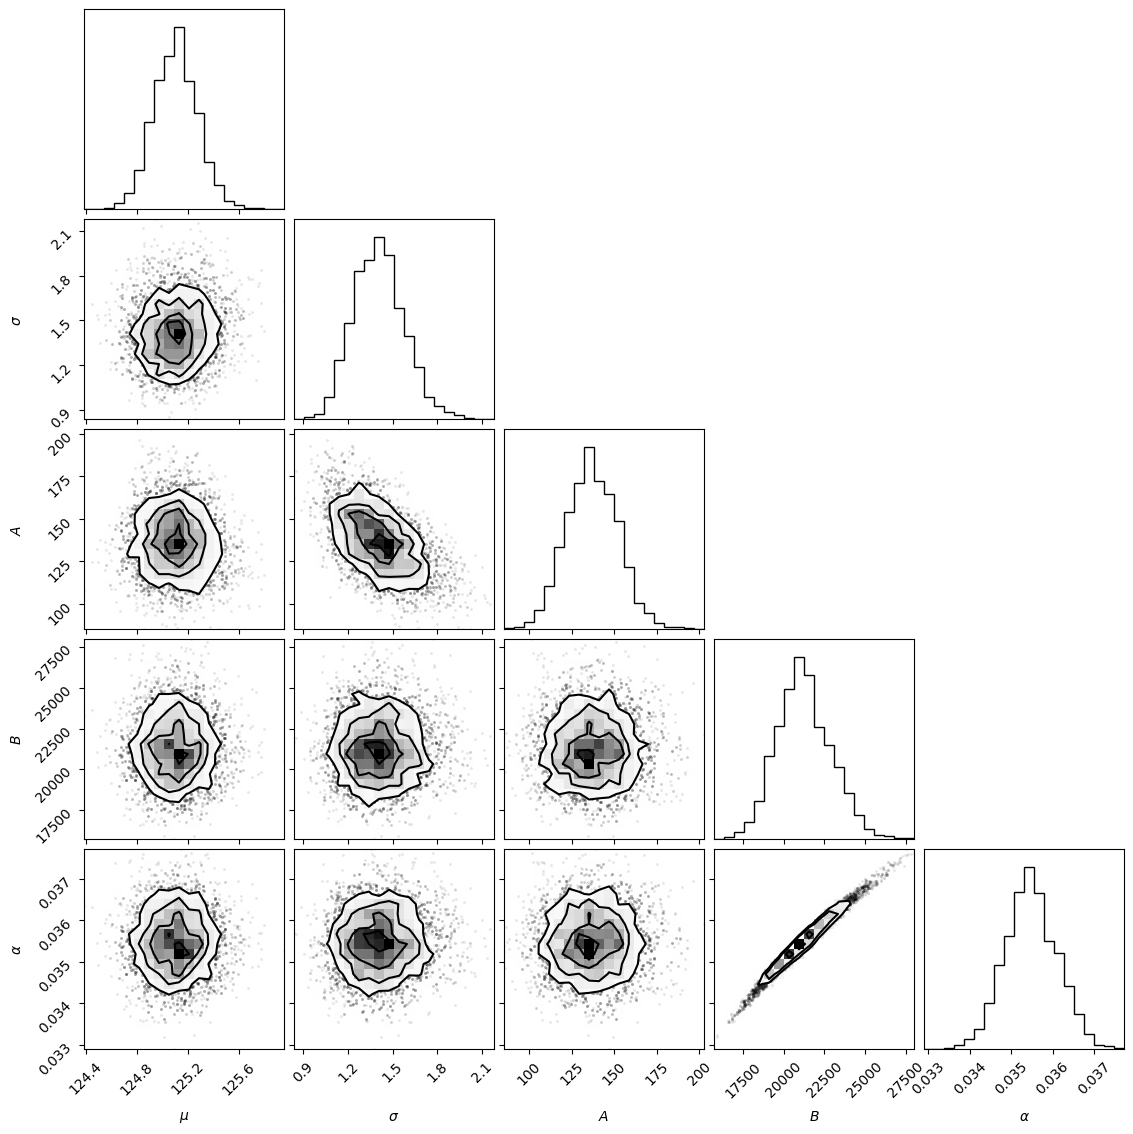

In [ ]:
import numpy as np
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

# Load binned data: m_i, n_i, dm
m, n, dm = np.load("data/higgs_binned.npy").T

# Signal+background model
# lambda_i = dm * [A * exp(-(m-mu)^2/(2 sigma^2)) + B * exp(-alpha m)]

def model_signal_bg(theta):
    mu, sigma, A, B, alpha = theta
    signal = A * np.exp(-0.5 * ((m - mu) / sigma) ** 2)
    bkg = B * np.exp(-alpha * m)
    return dm * (signal + bkg)

# Background-only model (A = 0)

def model_bg(theta):
    B, alpha = theta
    return dm * (B * np.exp(-alpha * m))

# Poisson log-likelihood

def loglike_signal_bg(theta):
    lam = model_signal_bg(theta)
    # Avoid log(0)
    lam = np.clip(lam, 1e-300, None)
    return np.sum(n * np.log(lam) - lam)


def loglike_bg(theta):
    lam = model_bg(theta)
    lam = np.clip(lam, 1e-300, None)
    return np.sum(n * np.log(lam) - lam)

# Priors (adjust ranges as desired)
# mu in [110, 140], sigma in [0.5, 5], A in [0, 10^4], B in [0, 5x10^4], alpha in [0, 0.2]

def ptform_signal_bg(u):
    u_mu, u_sigma, u_A, u_B, u_alpha = u
    mu = 110 + 30 * u_mu
    sigma = 0.5 + 4.5 * u_sigma
    A = 10000 * u_A
    B = 50000 * u_B
    alpha = 0.2 * u_alpha
    return np.array([mu, sigma, A, B, alpha])

# Background-only priors: B in [0, 5x10^4], alpha in [0, 0.2]

def ptform_bg(u):
    u_B, u_alpha = u
    B = 50000 * u_B
    alpha = 0.2 * u_alpha
    return np.array([B, alpha])

# Run dynesty for both models
sampler_sb = dynesty.NestedSampler(loglike_signal_bg, ptform_signal_bg, ndim=5)
sampler_sb.run_nested()
res_sb = sampler_sb.results

sampler_bg = dynesty.NestedSampler(loglike_bg, ptform_bg, ndim=2)
sampler_bg.run_nested()
res_bg = sampler_bg.results

logZ_sb = res_sb.logz[-1]
logZ_bg = res_bg.logz[-1]
print("logZ(signal+bg):", logZ_sb)
print("logZ(bg only):", logZ_bg)
# recall that the Bayes factor is the ratio of evidences. Z_sb / Z_bg > 1 indicates preference for signal+background
print("log Bayes factor (SB/BG):", logZ_sb - logZ_bg)

# Posterior samples (equal-weight) for signal+background
weights_sb = np.exp(res_sb.logwt - res_sb.logz[-1])
samples_eq_sb = dyfunc.resample_equal(res_sb.samples, weights_sb)

# Corner plot for signal+background
try:
    import corner
    labels = [r"$\mu$", r"$\sigma$", r"$A$", r"$B$", r"$\alpha$"]
    corner.corner(samples_eq_sb, labels=labels)
except Exception as e:
    print("Install corner for a nicer plot:", e)


See the Lecture 11 bump-hunt solution section for a worked example.